# Introduction

This notebook uses the Baseline model implemented in PyTorch forecasting. The baseline model predicts future values by repeating the last know value. It loads the merged feature file created by the Data preparation notebook/script, then splits that into train/validation/test split. Then uses the pytorch trainer to fit the model. And finally plots the predictions and interpretations. 

# Imports

In [1]:
import os, gc
import numpy as np
import torch
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)
start = datetime.now()
print(f'Started at {start}')

Started at 2022-07-25 11:32:40.863899


# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Google colab

Set `running_on_colab` to true if you are running on google colab. They don't have these libraries installed by default. Uncomment the codes too if needed. They might be commented out since in .py script inline commands show errors.

Use only the pip install part if you are on rivanna, using a default tensorflow kernel.

In [3]:
running_on_colab = False

# if running_on_colab:
#     !pip install pytorch_lightning
#     !pip install pytorch_forecasting

#     from google.colab import drive

#     drive.mount('/content/drive')
#     %cd /content/drive/My Drive/TFT-pytorch/notebook

## Pytorch lightning and forecasting

In [24]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import RecurrentNetwork, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [26]:
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../results/RN_top_100_early_stopped_target_cleaned_scaled'
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_target_cleaned/Top_100.csv'

    # pass your intented configuration here
    # input features are always normalized. But keeping the targets features unscaled improves results
    # if you want to change some config, but not to create a new config file, just change the value
    # of the corresponding parameter in the config section
    configPath = '../configurations/top_100_early_stopped_target_cleaned_scaled.json'
    # Path/URL of the checkpoint from which training is resumed
    ckpt_model_path = None # os.path.join(checkpoint_folder, 'latest-epoch=7.ckpt')
    
    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

In [6]:
total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

(81000, 15)


,FIPS,AgeDist,HealthDisp,Name,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,Deaths,TimeFromStart,LinearSpace,SinWeekly,CosWeekly
0,4013,0.4991,0.3334,"Arizona, Maricopa",2020-02-28,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0328,-0.4339,-0.9010
1,4013,0.4991,0.3334,"Arizona, Maricopa",2020-02-29,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0328,-0.9749,-0.2225
2,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-01,0.0,0.0,0.0,1.0,0.0,0.0,2,0.0328,-0.7818,0.6235
3,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-02,0.0,0.0,0.0,1.0,0.0,0.0,3,0.0328,0.0000,1.0000
4,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-03,0.0,0.0,0.0,1.0,0.0,0.0,4,0.0328,0.7818,0.6235


# Config

In [7]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [8]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
model_params = parameters.model_parameters

# google colab doesn't utilize GPU properly for pytorch
# so increasing batch size forces more utilization
# not needed on rivanna or your local machine

if running_on_colab: 
    model_params.batch_size *= 16

max_prediction_length = model_params.target_sequence_length
max_encoder_length = model_params.input_sequence_length

# Seed

In [9]:
import random

def seed_torch(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    pl.seed_everything(seed)

seed_torch(model_params.seed)

Global seed set to 7


# Processing

In [10]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [11]:
train_start, validation_start, test_start = get_start_dates(parameters)
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

Modifying start dates of the splits to adapt to encoder input sequence length
Start dates for train 2020-03-03 00:00:00, validation 2021-12-07 00:00:00, test 2022-03-01 00:00:00


## Train validation test split and scaling

In [12]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 63700, validation samples 9100, test samples 9100
637 days of training, 78 days of validation data, 78 days of test data.


In [31]:
train_scaled, validation_scaled, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases', 'Deaths']


## Create dataset and dataloaders

In [57]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):

  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    lags={target:[7] for target in targets},
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    static_categoricals=['FIPS'],
    time_varying_unknown_reals = targets,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=model_params.batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=model_params.batch_size*8)

  return data_timeseries, dataloader

In [58]:
# actually the baseline model does no training
train_timeseries, train_dataloader = prepare_data(train_scaled, parameters, train=True)
_, validation_dataloader = prepare_data(validation_scaled, parameters)
_, test_dataloader = prepare_data(test_scaled, parameters)

# del validation_scaled, test_scaled
gc.collect()

2199

# Training

## Evaluation metric

In [22]:
def show_result(df: pd.DataFrame, targets=targets):    
    for target in targets:
        predicted_column = f'Predicted_{target}'
        y_true, y_pred = df[target].values, df[predicted_column].values

        mae, rmse, msle, smape, nnse = calculate_result(y_true, y_pred)
        print(f'Target {target}, MAE {mae:.5g}, RMSE {rmse:.5g}, MSLE {msle:.5g}, SMAPE {smape:0.5g}. NNSE {nnse:0.5g}.')
    print()

## Trainer and logger

In [23]:
import tensorflow as tf
# click this and locate the lightning_logs folder path and select that folder. 
# this will load tensorbaord visualization
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [59]:
# notice that the early stopping patience is very high (60) for the old
# TF1 notebook. To reproduce that, replace patience=60
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=model_params.early_stopping_patience
    , verbose=True, mode="min"
)

# https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.ModelCheckpoint.html
best_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, monitor="val_loss", filename="best-{epoch}"
)
latest_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=args.checkpoint_folder, every_n_epochs=1, filename="latest-{epoch}"
)

logger = TensorBoardLogger(args.result_folder)  # logging results to a tensorboard

# https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-class-api
trainer = pl.Trainer(
    max_epochs = model_params.epochs,
    accelerator = 'auto',
    weights_summary = "top",
    gradient_clip_val = model_params.clipnorm,
    callbacks = [early_stop_callback, best_checkpoint, latest_checkpoint],
    logger = logger,
    enable_progress_bar = args.show_progress_bar,
    check_val_every_n_epoch = 1,
    # max_time="00:12:00:00",
    # auto_scale_batch_size = False 
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Model

In [60]:
# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.rnn.RecurrentNetwork.html
model = RecurrentNetwork.from_dataset(
    train_timeseries,
    learning_rate= model_params.learning_rate,
    # dropout=model_params.dropout_rate,

    hidden_size= 10, # model_params.hidden_layer_size,
    rnn_layers= 2,
    cell_type='LSTM', # 'GRU'
    # loss=MultiHorizonMetric([RMSE(reduction='mean') for _ in targets]), # RMSE(reduction='sqrt-mean')
    optimizer='adam',
    log_interval=1,
    # reduce_on_plateau_patience=2
)

In [61]:
from datetime import datetime

gc.collect()

start = datetime.now()
print(f'\n----Training started at {start}----\n')

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
    ckpt_path=args.ckpt_model_path
)
end = datetime.now()
print(f'\n----Training ended at {end}, elapsed time {end-start}')
print(f'Best model by validation loss saved at {trainer.checkpoint_callback.best_model_path}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MultiLoss      | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 2.1 K 
3 | rnn              | LSTM           | 2.4 K 
4 | output_projector | ModuleList     | 22    
----------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)



----Training started at 2022-07-25 12:27:44.115936----



Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.048


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.048


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.046


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.046


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.046. Signaling Trainer to stop.



----Training ended at 2022-07-25 12:40:58.407320, elapsed time 0:13:14.291384
Best model by validation loss saved at D:\COVID-19-forecast\TFT-pytorch\results\RN_top_100_early_stopped_target_cleaned_scaled\checkpoints\best-epoch=5.ckpt


# Prediction Processor

In [62]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

# Evaluate

## PlotResults

In [63]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

## Train results


---Training results--



Predict:   0%|          | 0/118 [00:00<?, ? batches/s]

Target Cases, MAE 115.48, RMSE 306.03, MSLE 2.4114, SMAPE 0.5871. NNSE 0.7961.
Target Deaths, MAE 2.5331, RMSE 6.6089, MSLE 0.5285, SMAPE 0.80481. NNSE 0.75554.



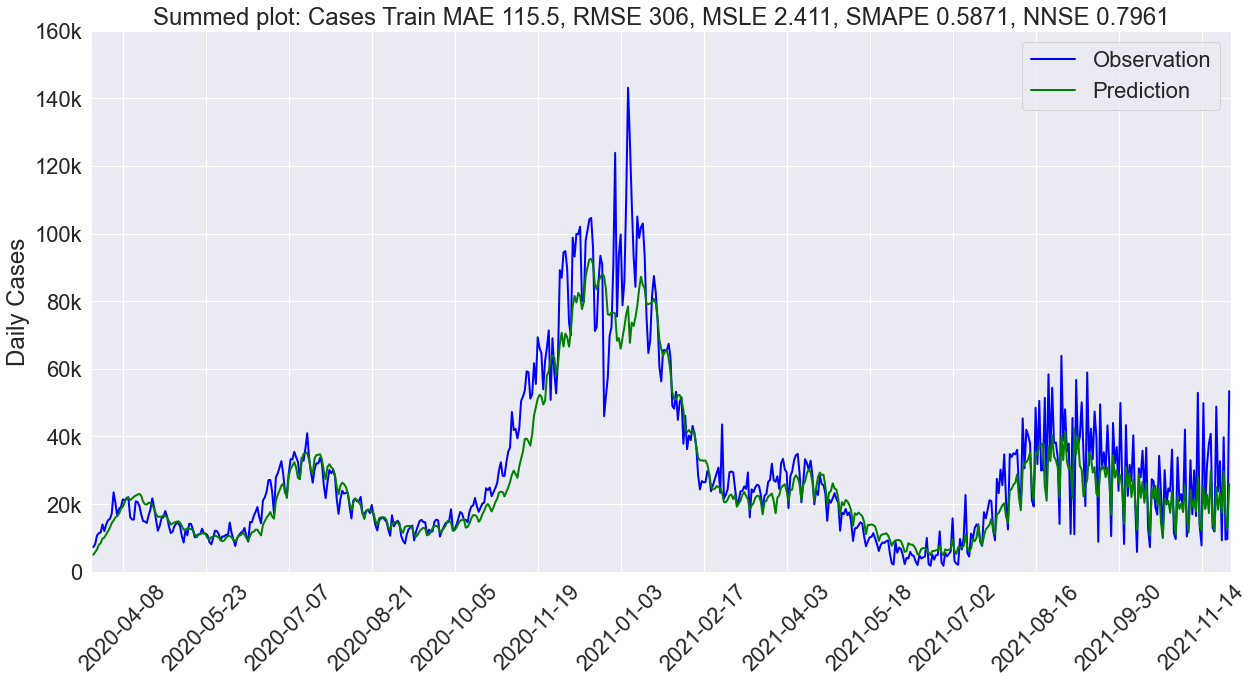

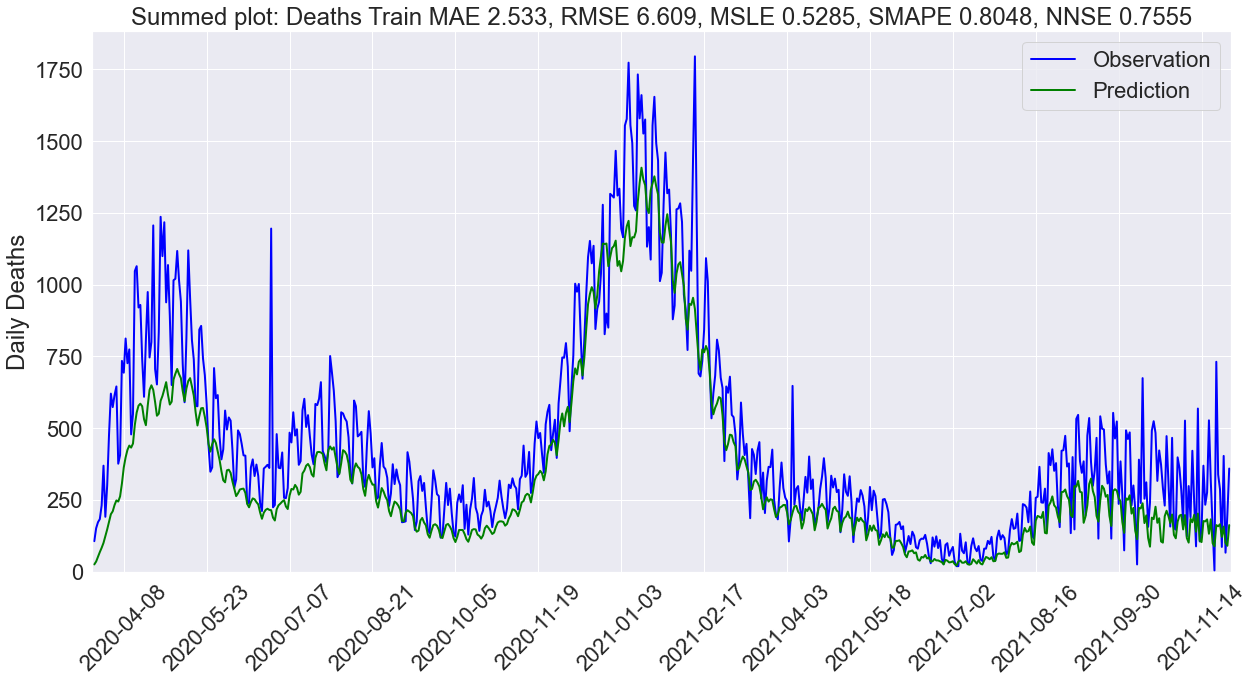

7963

In [64]:
_, train_dataloader = prepare_data(train_scaled, parameters) 
print(f'\n---Training results--\n')

train_predictions, train_index = model.predict(
    train_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

train_predictions = upscale_prediction(targets, train_predictions, target_scaler, max_prediction_length)
train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)
show_result(train_result_merged)
plotter.summed_plot(train_result_merged, type='Train' , base=45)
gc.collect()

## Validation results


---Validation results--



Predict:   0%|          | 0/12 [00:00<?, ? batches/s]

Target Cases, MAE 565.01, RMSE 1136.4, MSLE 6.0978, SMAPE 1.0524. NNSE 0.55834.
Target Deaths, MAE 5.1283, RMSE 11.84, MSLE 1.0834, SMAPE 1.0448. NNSE 0.56931.



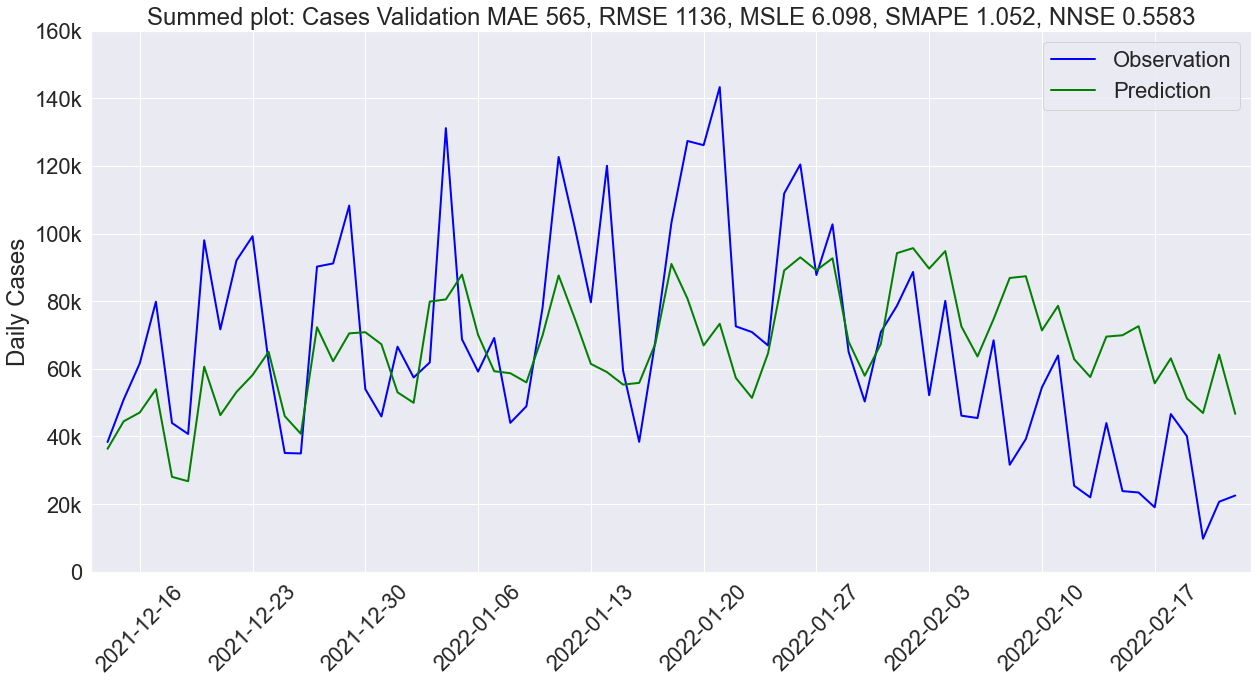

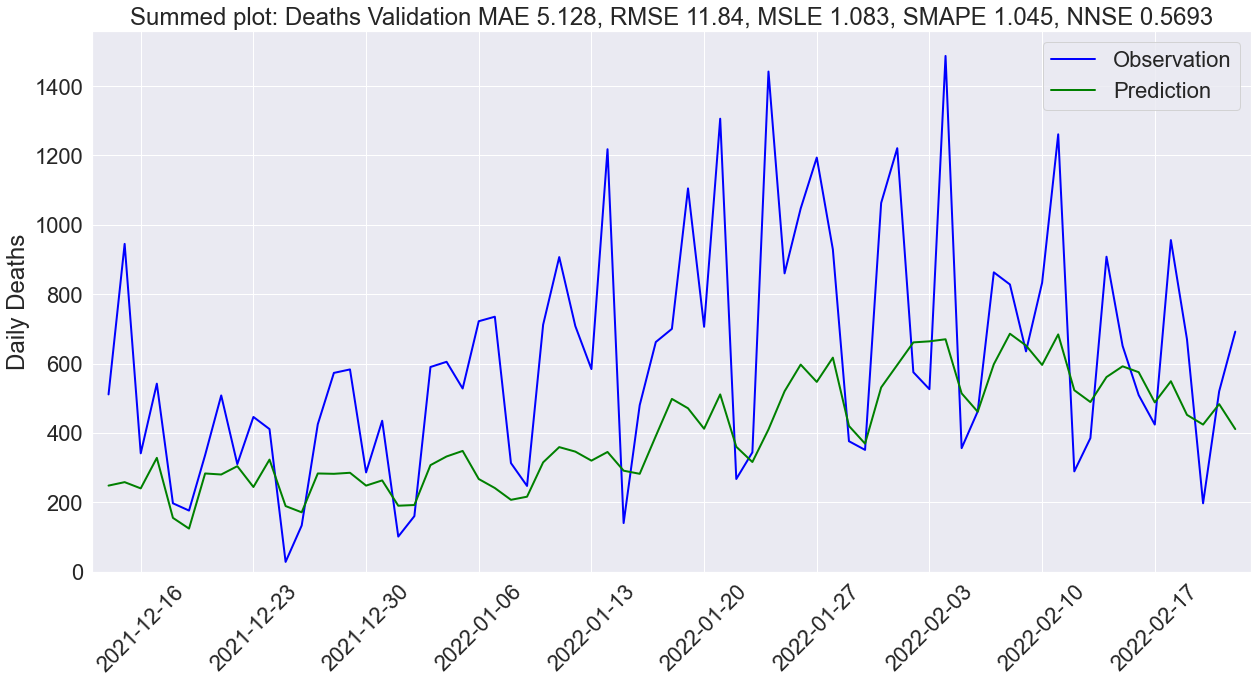

7369

In [65]:
print(f'\n---Validation results--\n')
validation_predictions, validation_index = model.predict(
    validation_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)
validation_predictions = upscale_prediction(targets, validation_predictions, target_scaler, max_prediction_length)

validation_result_merged = processor.align_result_with_dataset(validation_data, validation_predictions, validation_index)
show_result(validation_result_merged)
plotter.summed_plot(validation_result_merged, type='Validation')
gc.collect()

## Test results


---Test results--



Predict:   0%|          | 0/12 [00:00<?, ? batches/s]

Target Cases, MAE 157.32, RMSE 421.37, MSLE 6.5688, SMAPE 1.1471. NNSE 0.59342.
Target Deaths, MAE 1.4039, RMSE 4.5558, MSLE 0.47615, SMAPE 0.7322. NNSE 0.55558.



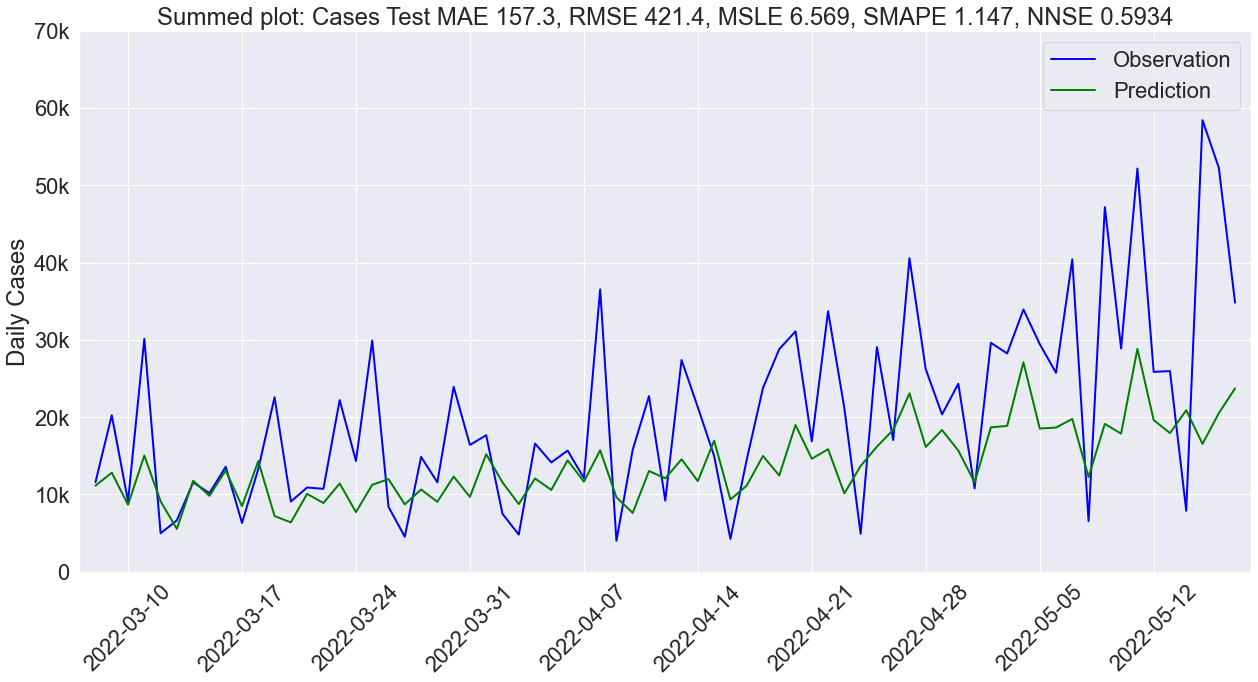

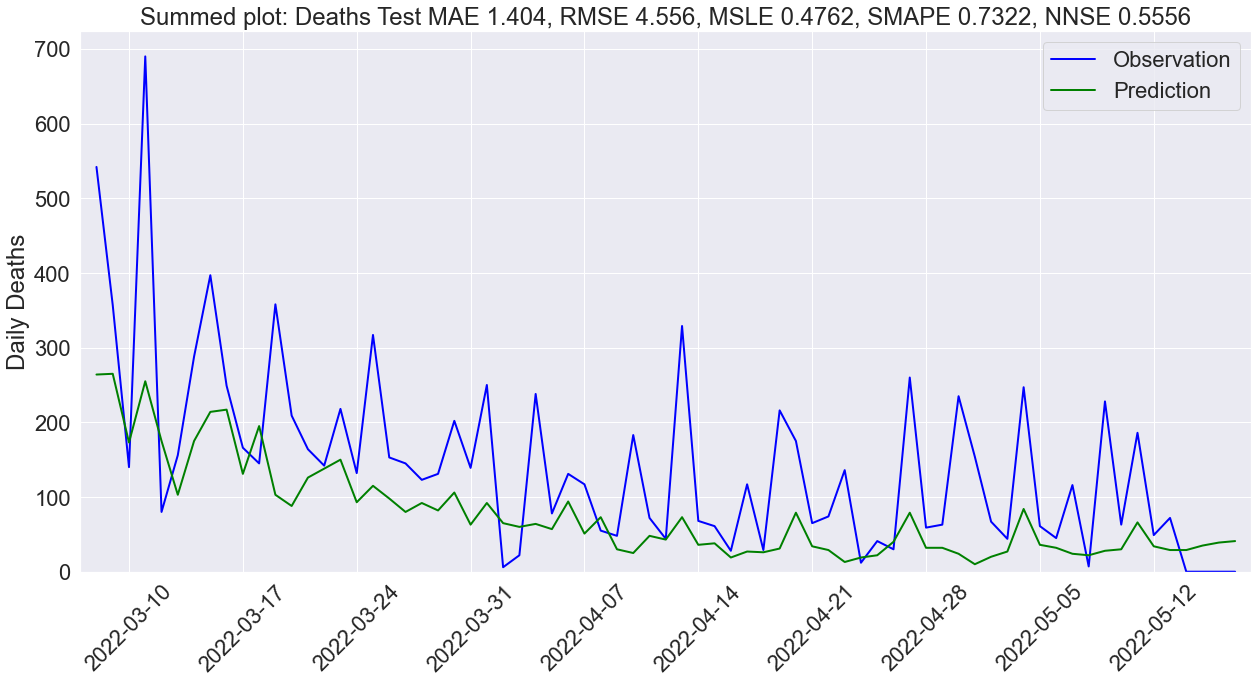

7293

In [66]:
print(f'\n---Test results--\n')
test_predictions, test_index = model.predict(
    test_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)
test_predictions = upscale_prediction(targets, test_predictions, target_scaler, max_prediction_length)

test_result_merged = processor.align_result_with_dataset(test_data, test_predictions, test_index)
show_result(test_result_merged)
plotter.summed_plot(test_result_merged, 'Test')
gc.collect()

## Dump results

In [67]:
train_result_merged['split'] = 'train'
validation_result_merged['split'] = 'validation'
test_result_merged['split'] = 'test'
df = pd.concat([train_result_merged, validation_result_merged, test_result_merged])
df.to_csv(os.path.join(args.result_folder, 'predictions_case_death.csv'), index=False)

df.head()

,FIPS,TimeFromStart,Predicted_Cases,Predicted_Deaths,Cases,Deaths,Date,split
0,11001,20,18.0,0.0,21.0,0.0,2020-03-23,train
1,12011,20,24.0,0.0,46.0,0.0,2020-03-23,train
2,12031,20,12.0,0.0,11.0,1.0,2020-03-23,train
3,12057,20,16.0,0.0,17.0,0.0,2020-03-23,train
4,12071,20,3.0,0.0,4.0,0.0,2020-03-23,train


In [68]:
del train_predictions, validation_predictions, test_predictions
del train_result_merged, validation_result_merged, test_result_merged, df
gc.collect()

0

In [69]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')

Ended at 2022-07-25 12:43:20.570860. Elapsed time 0:15:36.454924
